# Term Deposite Sale Ensemble Techniques

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn library imports.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats

# calculate accuracy measures and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve
from yellowbrick.classifier import ClassificationReport, ROCAUC

# Add plotly libs for some interactive charts
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Ensemble models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [235]:
# read csv and check data shape
bank_df = pd.read_csv("bank.csv")
bank_df = bank_df.sample(frac=1).reset_index(drop=True)
bank_df.shape

(11162, 17)

In [236]:
# data info, which type of data is used in column.
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


### All data fields are filled with data

In [237]:
# checking null values
bank_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### Data Does not have any missiong values or empty values.

In [238]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,49,blue-collar,married,secondary,no,-454,yes,no,cellular,14,may,558,1,-1,0,unknown,yes
1,25,blue-collar,single,secondary,no,1243,no,yes,cellular,10,jul,1341,7,-1,0,unknown,yes
2,53,technician,married,secondary,no,4930,no,yes,cellular,2,feb,228,2,-1,0,unknown,no
3,25,management,married,tertiary,no,-242,yes,yes,cellular,18,may,600,4,332,4,other,yes
4,29,technician,married,secondary,no,1180,yes,no,cellular,17,apr,367,3,323,3,failure,yes


### By observing data frame, data has two types, categorial variables and numercal variable. age,balance,duration,campaigns,pdays,previous are numerical aka countinu variable while, job,maritial, education,default, housing, loan,contact, month, poutcome Target are categorial variable

In [239]:
# Check data frame numerical variable five point summary
bank_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


### Looking at five point summary description, looks data is highly unbalance for pdays,campaign and previous 

In [240]:
"""
Bank data is mostly clean i.e not contain a empty or null values, numeric values seem ok as well, 
However, It contains lots of categorical decsription like yes/no. convert this columns to 0/1
"""
# Bank data is not uniform and has verbal columns like yes/no. conver this to numeric value like 0/1
categorial_coulmns = ["default","loan","housing","deposit"]
for i in categorial_coulmns:
    bank_df[i] = bank_df[i].apply(lambda x:0 if x == "no" else 1)

In [241]:
# For EDA, Define necessary functions.
def plot_variable_colums(category,horizontal=3, verticle=2):
    figure, ax = plt.subplots(horizontal, verticle, figsize=(20, 20))
    for var, subplot in zip(category, ax.flatten()):
        sns.distplot(bank_df[var], ax=subplot,bins=10, color="lime",kde=False)
def plot_categorial_count(category,horizontal=5, verticle=2):
    figure, ax = plt.subplots(horizontal, verticle, figsize=(20, 20))
    for cat, subplot in zip(category, ax.flatten()):
        sns.countplot(y=cat, data=bank_df, ax=subplot,orient="h",edgecolor="k")
def plot_categorial_count_with_context_of_target(category,horizontal=5, verticle=2):
    figure, ax = plt.subplots(horizontal, verticle, figsize=(20, 20))
    for cat, subplot in zip(category, ax.flatten()):
        sns.countplot(x=cat, data=bank_df, ax=subplot, hue="deposit",edgecolor="k")
def plot_box_plots_for_numeric_variable(category,horizontal=3, verticle=2):
    figure, ax = plt.subplots(horizontal, verticle, figsize=(20, 20))
    for var, subplot in zip(category, ax.flatten()):
        #x="day", y="total_bill", data=tips)
        sns.boxplot(x=var, data=bank_df, ax=subplot)
def number_of_unique_in_each_category(countcat):
    for col in countcat:
        print(bank_df[col].value_counts())
def plot_target_frquency_distribution(category,xlabel,ylabel,title,bw=1.0):  
    fig = plt.figure(figsize=(10,5),)
    ax=sns.kdeplot(bank_df.loc[(bank_df['deposit'] == 0),category] , color='red',shade=True,label='Reject',bw=bw)
    ax=sns.kdeplot(bank_df.loc[(bank_df['deposit'] == 1),category] , color='green',shade=True, label='Accept',bw=bw)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.title(title)
def campaign_target_analysis():
    sns.countplot(bank_df["deposit"])
    accepted_subscription = len(bank_df[bank_df["deposit"]==1])
    rejected_subscription = len(bank_df[bank_df["deposit"]==0])
    approval_percentage = ((accepted_subscription)/(accepted_subscription + rejected_subscription)*100)
    rejected_percentage = ((rejected_subscription)/(accepted_subscription + rejected_subscription)*100)
    print("Percentage people accepting term subscription is: {}% and percentage people rejecting term subscription is: {}%".format(approval_percentage,rejected_percentage))

In [242]:
# define countines,categorical variables
countinue_variable_colums = ["age","balance","duration","pdays","day","previous","campaign"]
categorical_variable = ["job","marital","education","default","housing","loan","contact","month","poutcome"]

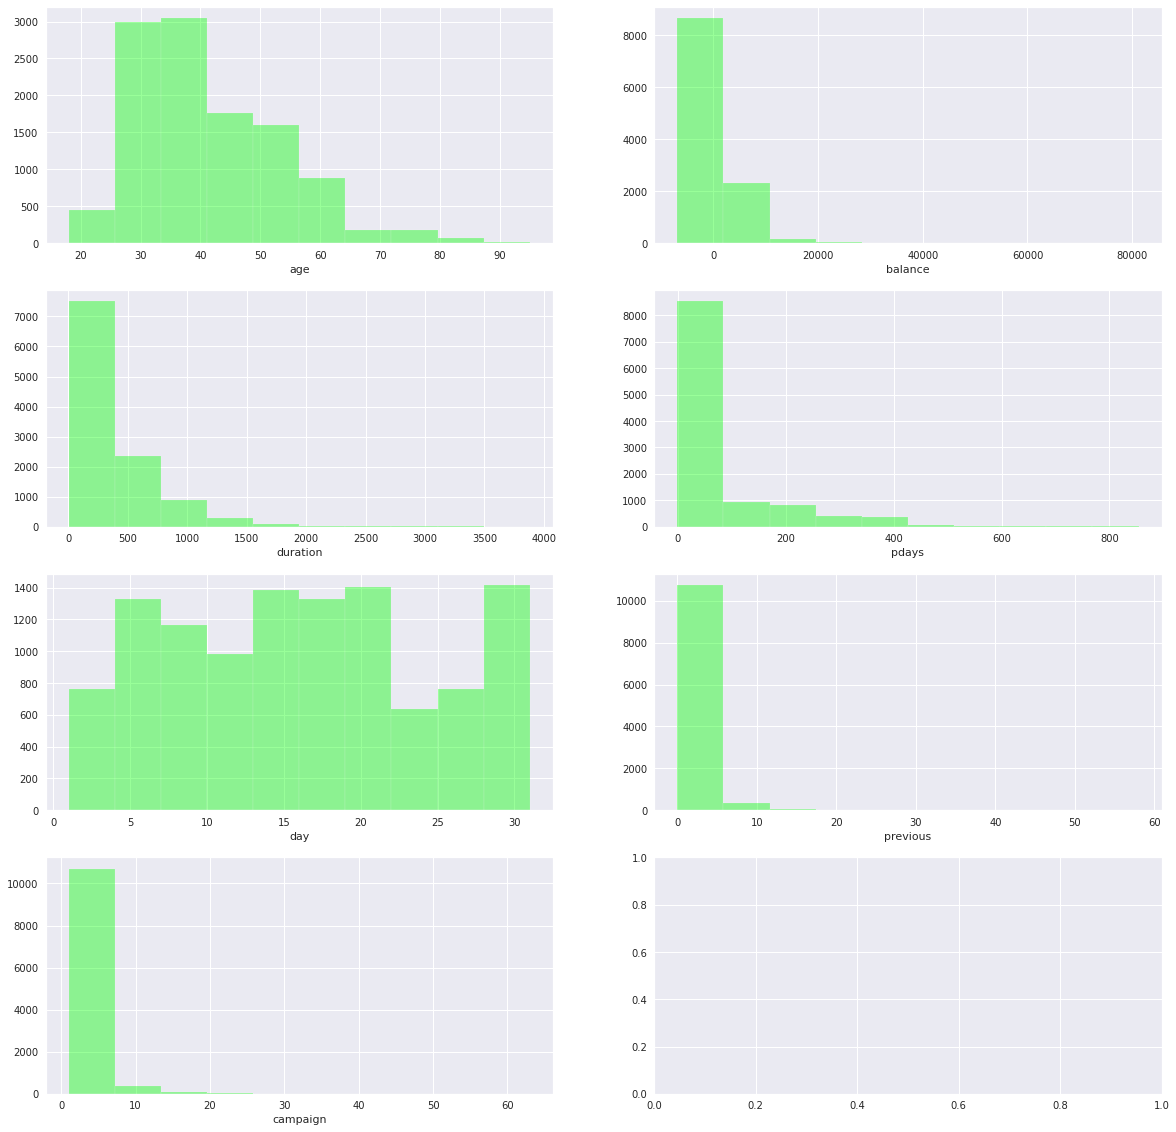

In [243]:
# Plot Countinue varible columns and its distribution.
sns.set_style("darkgrid")
plot_variable_colums(countinue_variable_colums,horizontal=4,verticle=2)

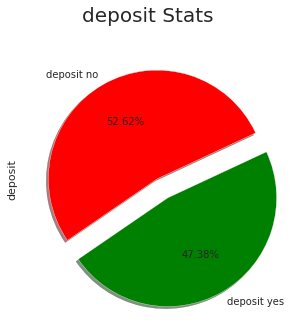

In [244]:
# Statistics on Target Value
f, ax = plt.subplots(1,1,figsize=(10,5))

colors = ["red","green"]
labels ="deposit no", "deposit yes"

plt.suptitle('deposit Stats', fontsize=20)

bank_df["deposit"].value_counts().plot.pie(explode=[0,0.20], autopct='%1.2f%%', ax=ax, shadow=True, colors=colors, 
                                             labels=labels, fontsize=10, startangle=25)

Percentage people accepting term subscription is: 47.38398136534671% and percentage people rejecting term subscription is: 52.61601863465329%


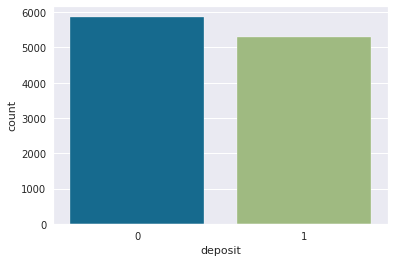

In [245]:
campaign_target_analysis()

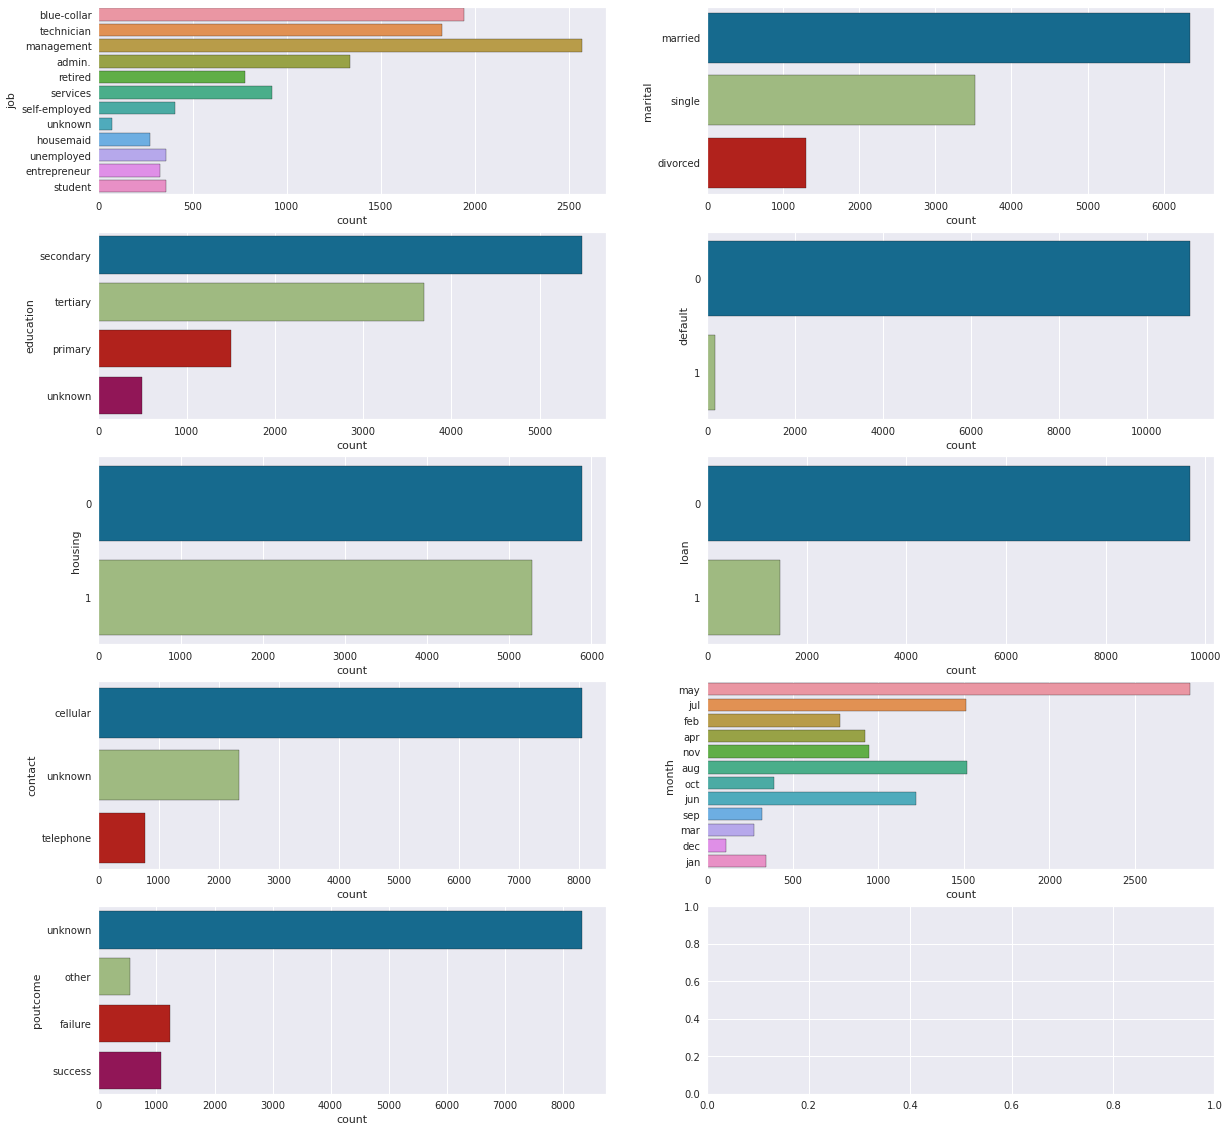

In [246]:
# Check Counts for categorical variables
plot_categorial_count(categorical_variable)

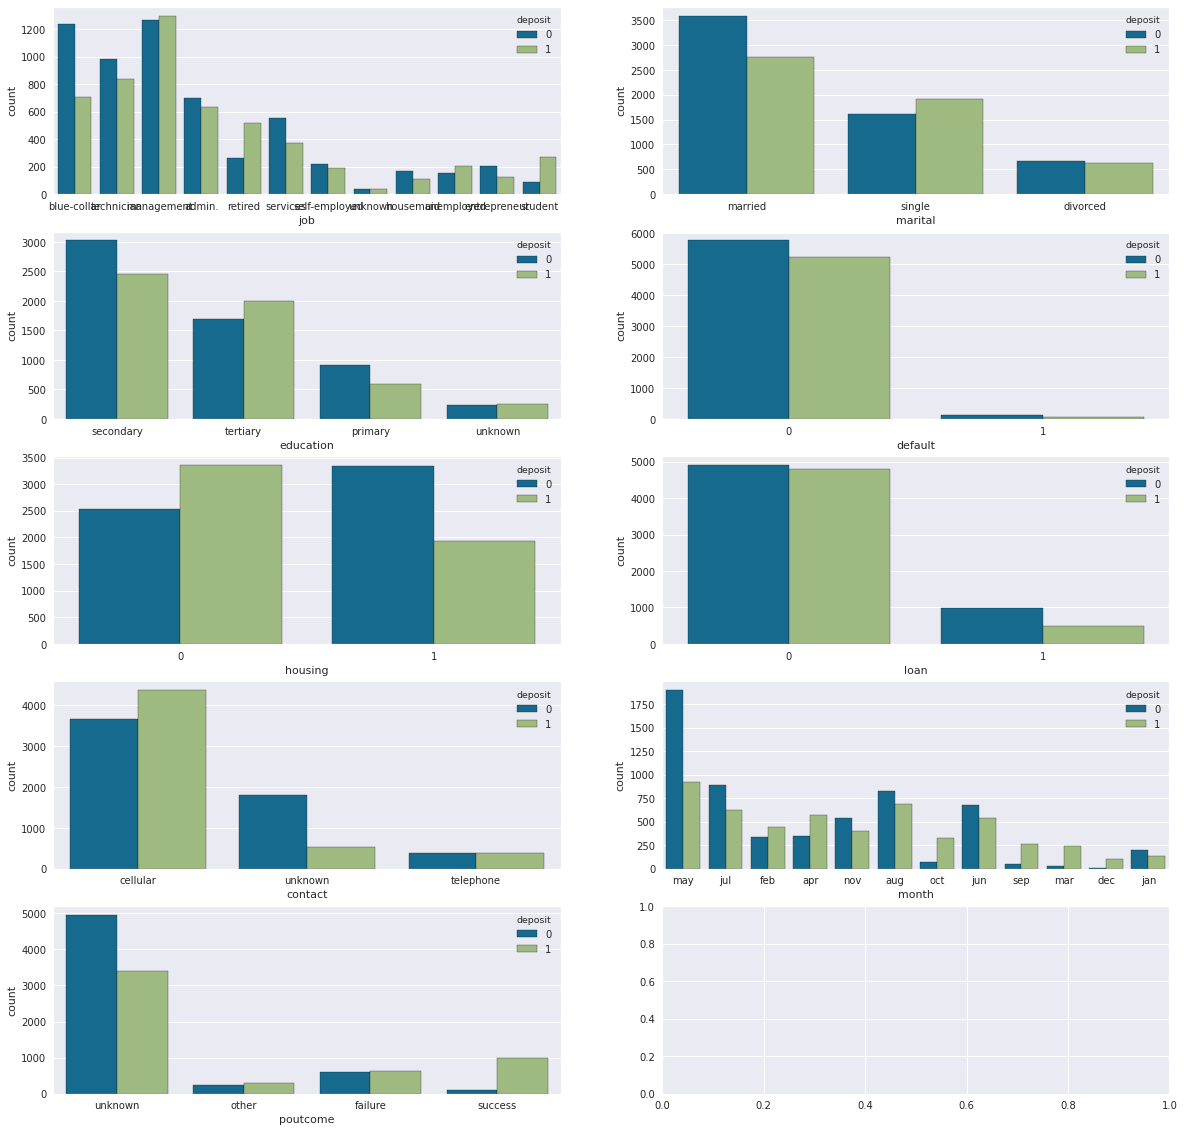

In [247]:
# Now plot categorical data on context of Target, i.e accpted Target by categorical data
plot_categorial_count_with_context_of_target(categorical_variable);

In [248]:
# check pair plot multi variant anyalisis for all data frame columns.
#sns.pairplot(bank_df);

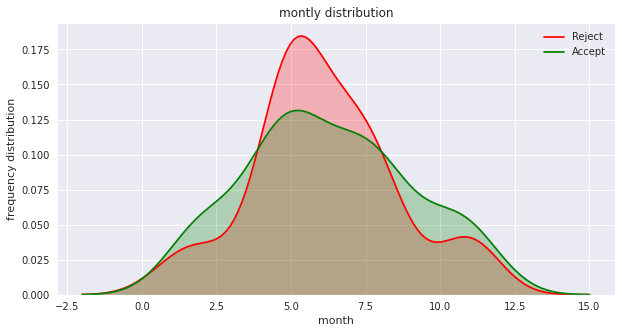

In [249]:
# Lets check some more  facts on Accpting / Rejecting Term Deposite on given data 
# Convert all months to number 
lst = [bank_df]
for column in lst:
    column.loc[column["month"] == "jan", "month_num"] = 1
    column.loc[column["month"] == "feb", "month_num"] = 2
    column.loc[column["month"] == "mar", "month_num"] = 3
    column.loc[column["month"] == "apr", "month_num"] = 4
    column.loc[column["month"] == "may", "month_num"] = 5
    column.loc[column["month"] == "jun", "month_num"] = 6
    column.loc[column["month"] == "jul", "month_num"] = 7
    column.loc[column["month"] == "aug", "month_num"] = 8
    column.loc[column["month"] == "sep", "month_num"] = 9
    column.loc[column["month"] == "oct", "month_num"] = 10
    column.loc[column["month"] == "nov", "month_num"] = 11
    column.loc[column["month"] == "dec", "month_num"] = 12
# Plot monthly accept/reject distribution
plot_target_frquency_distribution("month_num","month","frequency distribution","montly distribution")

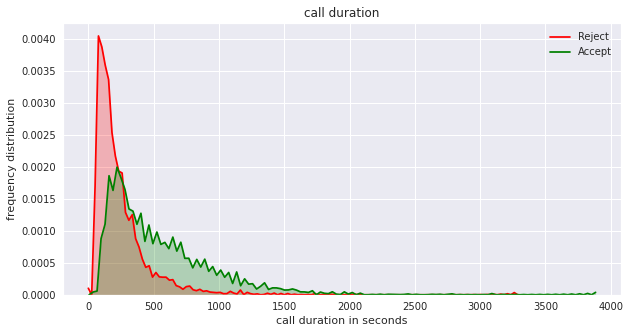

In [250]:
# Plot call duration wise accept/reject distribution
plot_target_frquency_distribution("duration","call duration in seconds","frequency distribution","call duration")

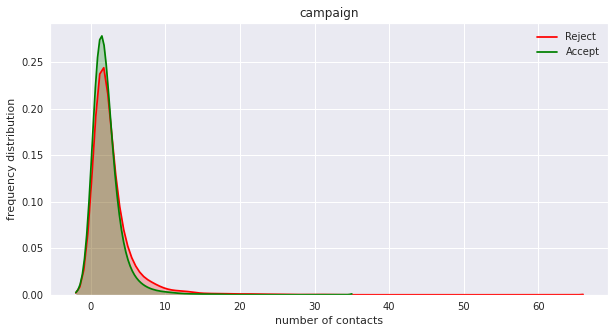

In [251]:
# Plot call campaign wise accept/reject distribution
plot_target_frquency_distribution("campaign","number of contacts","frequency distribution","campaign")

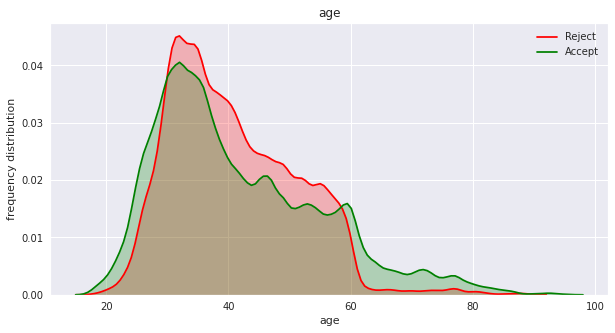

In [252]:
# Plot age v/s accept/reject distribution
plot_target_frquency_distribution("age","age","frequency distribution","age")

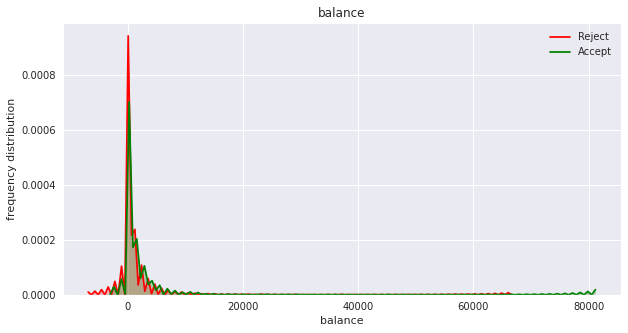

In [253]:
# Plot balance v/s accept/reject distribution
plot_target_frquency_distribution("balance","balance","frequency distribution","balance")

In [254]:
# Convert -1 to number 900
def convert_pdays(x):
    if x == -1:
        return 900
    else:
        return x
bank_df["pdays"] = bank_df["pdays"].apply(convert_pdays)

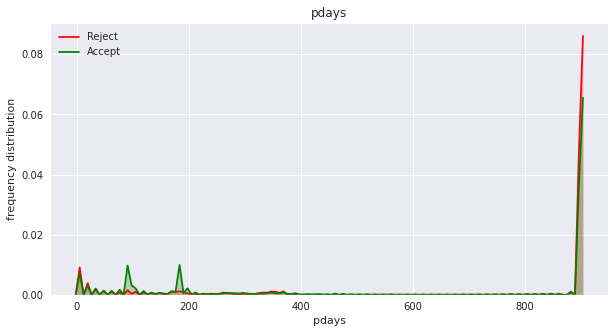

In [255]:
# Plot pdays v/s accept/reject distribution
plot_target_frquency_distribution("pdays","pdays","frequency distribution","pdays")

In [256]:
anayltical_countines_varialbes = ["age","balance","duration","pdays","campaign","previous"]

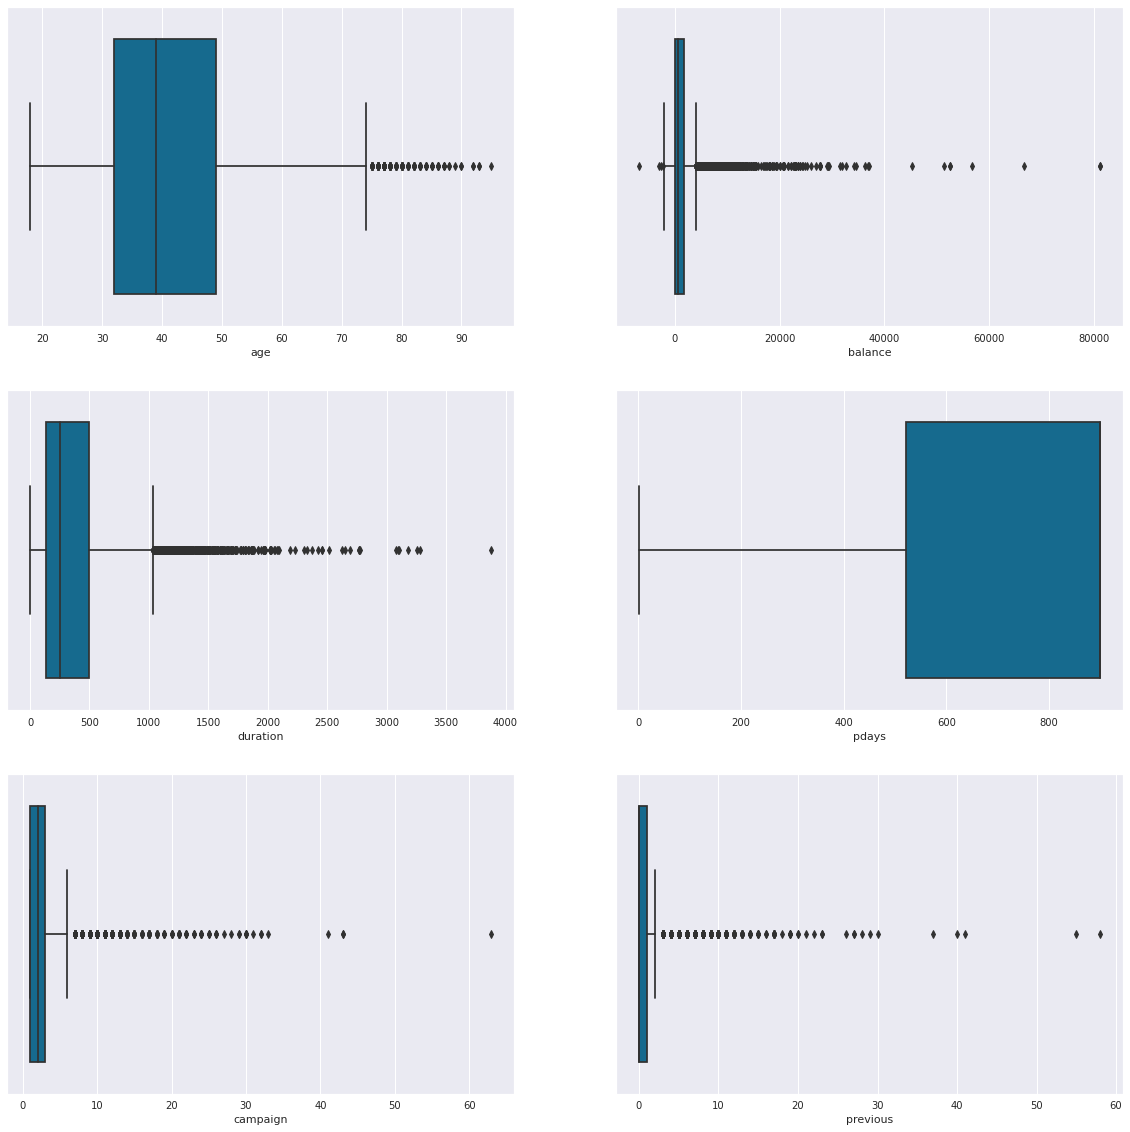

In [257]:
# Box plot for outliers countinues variables
plot_box_plots_for_numeric_variable(anayltical_countines_varialbes)

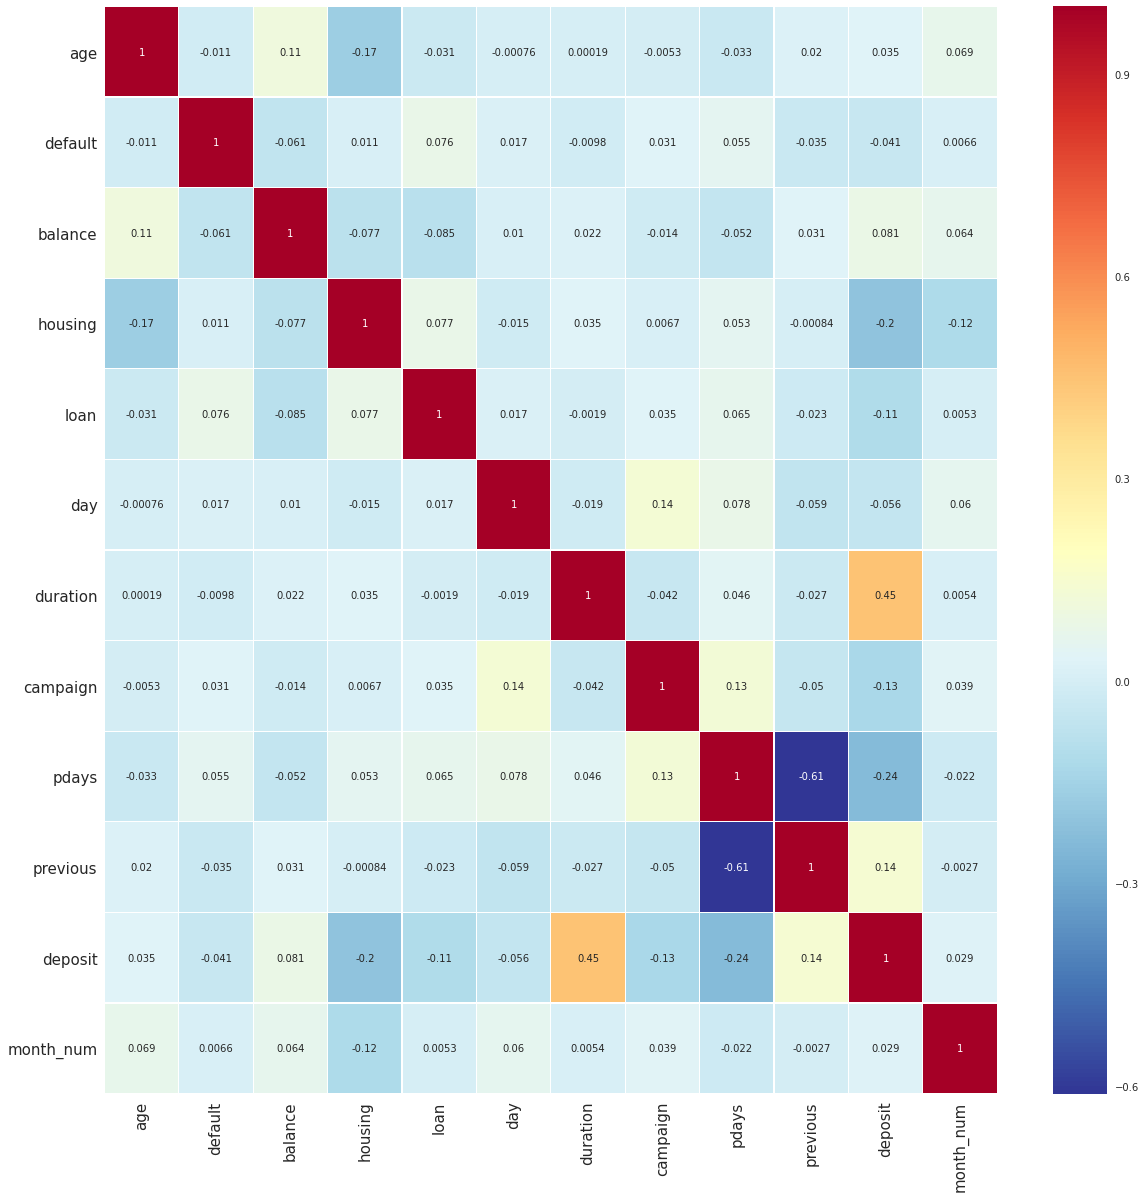

In [258]:
# Create Correlation Heat map for finding The most relevent feature
corr = bank_df.corr()
sns.heatmap(corr,annot=True,cmap='RdYlBu_r',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Exploratory data quality report  & Insights from data

1) By observing data figures,stats, some of the data variables are highly non-uniform, i.e distributed highly on either right side or left side of distribution.

2) Highly non-uniformlay variables are duration,pdays,previous,campaign,balance.

3) Term deposite Sale Success/ Failure percentage is  11%, 89% which indicates that majority people are not subscribing term deposite.

4) some data fields need to conver into digits to represnt their numeric True/False values. i.e yes/no type of answer need to convert into 1/0.

5) call duration is the relatively high (~0.4) and only clear variable is affceting Target. means higher call duration increase the Target success higher.

6) numbers of contacts < 5 has higher distribution of Target success, means people who get contancted less than 5 has higher probablity of accepting Term Deposite.

7) At age distribution graph, x > 60 has success/ failure ratio > 1 that indicates, people with age > 60 has higher chance to accepting term deposite.

8) People who has less call duration, are more likely to reject term deposite.

9) Successful outcome from previous campaign is affceting current campaign, People who has  previous outcome (poutcome) is success are likely to accept term deposite.

10) People with higher education(Tertiary) are more likely to accept term deposite.

11) People who are defaulter are less likely accept term deposite which makes more sense since they may not have money to deposite.

12) People who contacted in March are more likely to accpet term deposite while people in conatcted in month of May are less likelty to accept term deposite.



# Prepare the data for analysis

In [259]:
# Convert some non-uniform countinue values in category for better model feed
# Categories balance into three category,
bank_df['balance'] = pd.cut(x=bank_df['balance'], bins=[-20000,0,5000,10000,120000], labels=["negative","low","medium","high"], right=False)
# convert age into age groups
bank_df['age'] = pd.cut(x=bank_df['age'], bins=[10,20,30,40,50,60,70,80,90], labels=["20s","30s","40s","50s","60s","70s","80s","90s"], right=False)
# convert pdays into category 
bank_df['pdays'] = pd.cut(x=bank_df['pdays'], bins=[0,100,200,400,1000], labels=["early","in_time","late","never"], right=False)


In [260]:
# Discard some data that is highly non-uniformly distributed
# Now call duration is the most correlated factor, by looking at graph we can see that lots of noise in < 60 second, filter that duration
bank_df = bank_df[bank_df["duration"] > 60]
# also campaign > 10 are kind of useless
bank_df = bank_df[bank_df["campaign"] < 10]
# also previous < 5 are kind of useless
bank_df = bank_df[bank_df["previous"] < 4]


In [261]:
# now convert all categorical variable to numeric variable by using one hot encoding
bank_df = pd.get_dummies(bank_df, columns=['age','job','contact',"marital","education","campaign","pdays","previous","poutcome","balance"])

In [262]:
# discard day and month columns as they are irrelavant
bank_df.drop(["day","month"],inplace=True,axis=1)

In [263]:
bank_df = bank_df.reset_index()

In [264]:
# Perform 70:30 split for test and train data for model
features = [col for col in bank_df.columns if col != 'deposit']

X_train, X_test, y_train, y_test = train_test_split(bank_df[features], bank_df['deposit'], test_size=.3, random_state=42)
X_train.shape, X_test.shape

((6631, 61), (2842, 61))

# Create Ensemble model

In [265]:
# create function for model performance
def model_performance(model,X_train,X_test,y_train,y_test):
    viz = ClassificationReport(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    roc = ROCAUC(model)
    roc.fit(X_train, y_train)
    roc.score(X_test, y_test)
    roc.show()
    

# Now for cheking model performance, define some useful score functions.
def get_confusion_matrix( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()
    
# Check model performance parameters.Like Confusion Matrix,model score on training/testing,recall,precision.
def get_models_matrix(model,X_train,X_test,y_train,y_test):
    y_predict = model.predict(X_test)
    get_confusion_matrix(y_test,y_predict)
    print("Recall:",recall_score(y_test,y_predict))
    print("Precision:",precision_score(y_test,y_predict))
    print("F1 Score:",f1_score(y_test,y_predict))
    print("Roc Auc Score:",roc_auc_score(y_test,y_predict))

#### Performance metrics

- __Precision__: Fraction of actuals per label that were correctly classified by the model
- __Recall__: Fraction of predictions that were correctly classified by the model
- __F1-score__: Weighted harmonic mean of the precision and recall. F1-score: 2 * (precision * recall) / (precision + recall)
- __Support__: Number of occurrences of each class in y_test
- __Accuracy__: Fraction of all observations that were correctly classified by the model
- __Macro avg__: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
- __Micro/weighted avg__: Calculate metrics globally by counting the total true positives, false negatives and false positives
- __AUC Score__: Given a random observation from the dataset that belongs to a class, and a random observation that doesn't belong to a class, the AUC is the perecentage of time that our model will classify which is which correctly

## Create model based on logistic regression and decision tree

In [266]:
# Create Logistic Regression Model
regmodel = LogisticRegression()

# train model
regmodel.fit(X_train,y_train)

# check score for regression model 
print("Training accuracy for regression model is :{}".format(regmodel.score(X_train,y_train)))
print("Testing accuracy for regression model is :{}".format(regmodel.score(X_test,y_test)))


Training accuracy for regression model is :0.7998793545468256
Testing accuracy for regression model is :0.8061224489795918


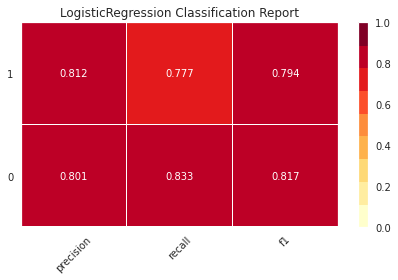

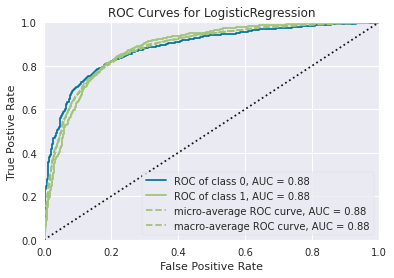

In [267]:
# Evaluate model by using confusion matix and AUC curve and F1 score
model_performance(regmodel,X_train,X_test,y_train,y_test)

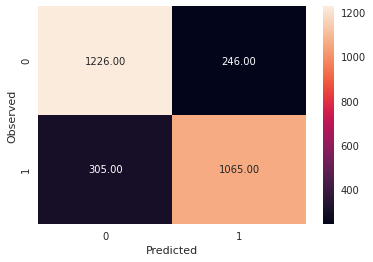

Recall: 0.7773722627737226
Precision: 0.8123569794050344
F1 Score: 0.794479671764267
Roc Auc Score: 0.8051263487781656


In [268]:
get_models_matrix(regmodel,X_train,X_test,y_train,y_test)

In [269]:
# Add this core to Performance dataframe

y_predict = regmodel.predict(X_test)
a = recall_score(y_test,y_predict)
b = precision_score(y_test,y_predict)
c = f1_score(y_test,y_predict)
d = roc_auc_score(y_test,y_predict)

In [270]:
# Also record this performance into dataframe
# also create one data frame for comparing model metrics
performanceDf = pd.DataFrame({'Method':['Logistic Regression'], 'accuracy': regmodel.score(X_test,y_test),'recall':a,'precision':b,'f1_score':c,'auc':d})
performanceDf = performanceDf[['Method', 'accuracy','recall','precision','f1_score','auc']]

### Logisitc regression model has good accuracy on test,train set but it has really bad recall on class 1. By mean it is not clearly classified potential customer accurately

In [271]:
# Create Decision tree model based on gini and evaluate
dtree_gini = DecisionTreeClassifier(criterion='gini')

# train model
dtree_gini.fit(X_train,y_train)

# check score for dtree model 
print("Training accuracy for regression model is :{}".format(dtree_gini.score(X_train,y_train)))
print("Testing accuracy for regression model is :{}".format(dtree_gini.score(X_test,y_test)))


Training accuracy for regression model is :1.0
Testing accuracy for regression model is :0.7543983110485574


### dtree_gini model has training set accuracy is 1 while test set accuracy is 0.87 that indicates the overfitting.

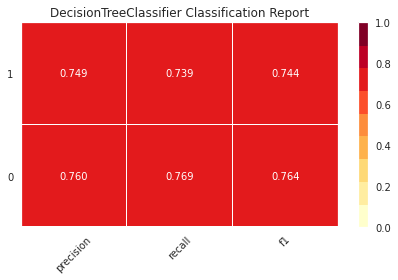

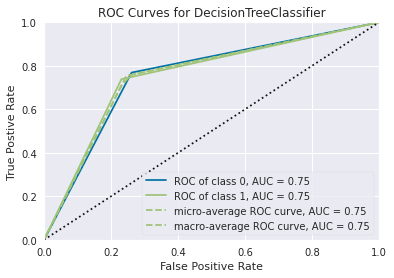

In [272]:
# Evaluate model by using confusion matix and AUC curve and F1 score
model_performance(dtree_gini,X_train,X_test,y_train,y_test)

### Because of the overfitting, dtree_gini model has lower RUC. Lets prune the decision tree and re evaluate

In [273]:
# Create Decision tree model based on gini and prune it.

depth_data = {}

for depth in range(1,20):
    clf_pruned = DecisionTreeClassifier(criterion = "gini", max_depth=depth)
    clf_pruned.fit(X_train, y_train)
    depth_data[depth] = {"Train":clf_pruned.score(X_train,y_train),"Test":clf_pruned.score(X_test,y_test)}

depth_data

{1: {'Train': 0.7083396169506861, 'Test': 0.7044334975369458},
 2: {'Train': 0.7501131051123511, 'Test': 0.7508796622097115},
 3: {'Train': 0.7546373096063942, 'Test': 0.7596762843068262},
 4: {'Train': 0.7599155481827778, 'Test': 0.7610837438423645},
 5: {'Train': 0.7826873774694616, 'Test': 0.7793807178043631},
 6: {'Train': 0.7974664454833359, 'Test': 0.7959183673469388},
 7: {'Train': 0.8215955361182326, 'Test': 0.802603800140746},
 8: {'Train': 0.8407480018096818, 'Test': 0.8011963406052076},
 9: {'Train': 0.8603528879505353, 'Test': 0.7973258268824771},
 10: {'Train': 0.8796561604584527, 'Test': 0.7895847994370162},
 11: {'Train': 0.8979037852510934, 'Test': 0.7906403940886699},
 12: {'Train': 0.9197707736389685, 'Test': 0.7892329345531316},
 13: {'Train': 0.9354546825516513, 'Test': 0.7748064743138635},
 14: {'Train': 0.9506861710149299, 'Test': 0.7790288529204785},
 15: {'Train': 0.9615442618006333, 'Test': 0.7755102040816326},
 16: {'Train': 0.9719499321369326, 'Test': 0.76002

In [274]:
# By looking at depth vs accuracy, the best accuracy get on depth 6.

In [275]:
 clf_pruned = DecisionTreeClassifier(criterion = "gini", max_depth=6)

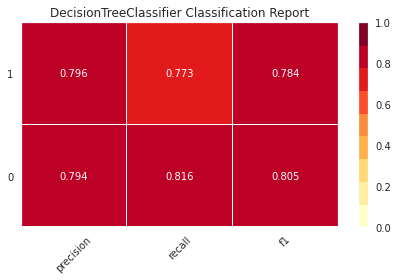

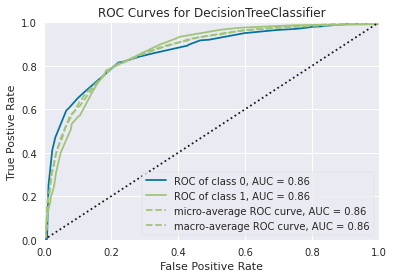

In [276]:
model_performance(clf_pruned,X_train,X_test,y_train,y_test)

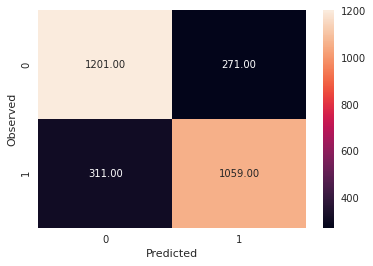

Recall: 0.772992700729927
Precision: 0.7962406015037594
F1 Score: 0.7844444444444445
Roc Auc Score: 0.7944447199301808


In [277]:
# Performance metric for pruned decision tree

get_models_matrix(clf_pruned,X_train,X_test,y_train,y_test)
# Add data to performance frame
y_predict = clf_pruned.predict(X_test)
a = recall_score(y_test,y_predict)
b = precision_score(y_test,y_predict)
c = f1_score(y_test,y_predict)
d = roc_auc_score(y_test,y_predict)
tmpeDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': clf_pruned.score(X_test,y_test),'recall':a,'precision':b,'f1_score':c,'auc':d})
performanceDf = pd.concat([performanceDf,tmpeDf])
performanceDf = performanceDf[['Method', 'accuracy','recall','precision','f1_score','auc']]

In [278]:
# Visulized decision tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz



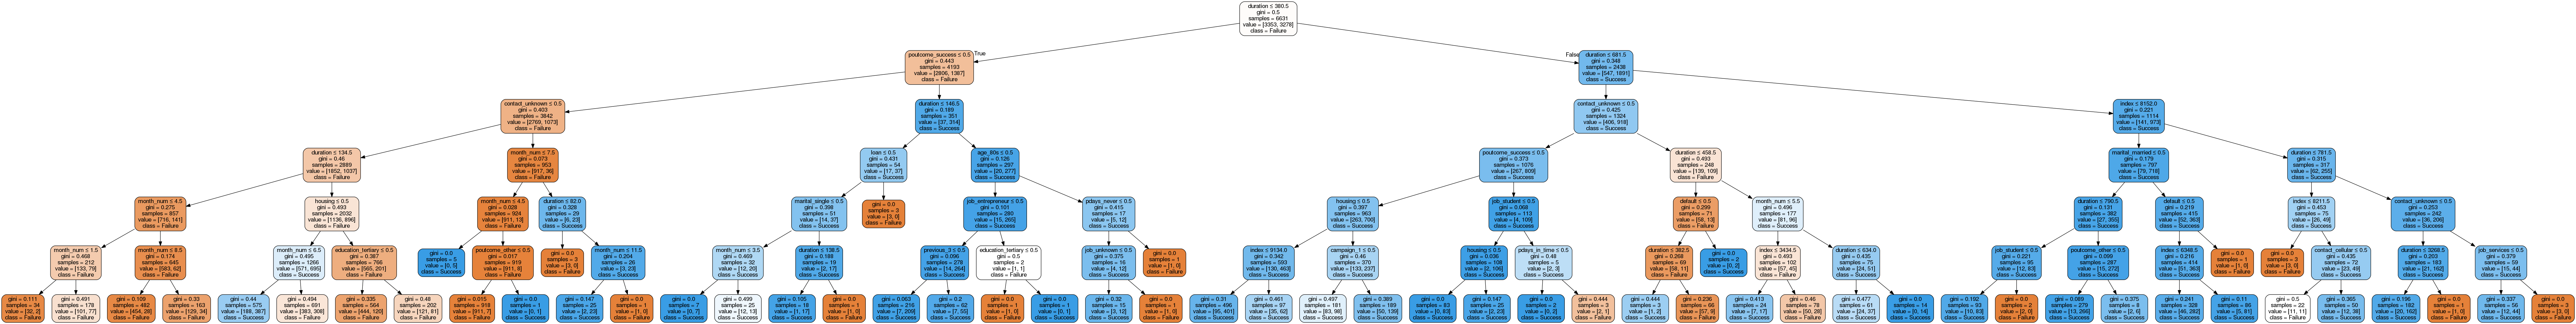

In [279]:
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['Failure','Success'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('term_deposite.png')
Image(graph.create_png())

### Conclusion: Purned Decision tree has recall/f1 score better than Logisitc regression on class=1. Both model has similar accuracy on train/test data. But decision tree can better identify customer who may subscribe to term deposite

## Create Ensemble model

##  Bagging classifier as ensemble model

In [280]:
# Create Bagging model by using Decision tree classifier,

# Use previously best decsion tree
dTree = DecisionTreeClassifier(criterion = "gini", max_depth=10)

# create with 50 trees
bgcl = BaggingClassifier(base_estimator=dTree,n_estimators=100, max_samples= .7, bootstrap=True, oob_score=True, random_state=42)
bgcl = bgcl.fit(X_train, y_train)


# check score for bagging model 
print("Training accuracy for bagging model is :{}".format(bgcl.score(X_train,y_train)))
print("Testing accuracy for bagging model is :{}".format(bgcl.score(X_test,y_test)))

Training accuracy for bagging model is :0.8932287739405821
Testing accuracy for bagging model is :0.8346235045742435


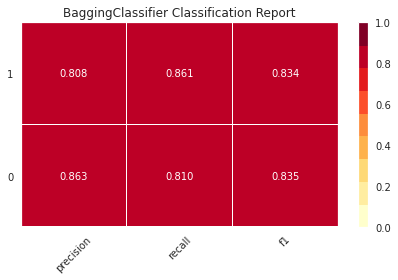

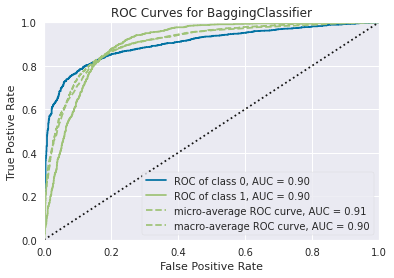

In [281]:
# Evaluate model by using confusion matix and AUC curve and F1 score
model_performance(bgcl,X_train,X_test,y_train,y_test)

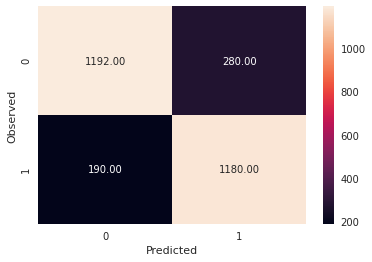

Recall: 0.8613138686131386
Precision: 0.8082191780821918
F1 Score: 0.8339222614840989
Roc Auc Score: 0.8355482386543954


In [282]:
get_models_matrix(bgcl,X_train,X_test,y_train,y_test)
# Add data to performance frame
y_predict = bgcl.predict(X_test)
a = recall_score(y_test,y_predict)
b = precision_score(y_test,y_predict)
c = f1_score(y_test,y_predict)
d = roc_auc_score(y_test,y_predict)
tmpeDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': bgcl.score(X_test,y_test),'recall':a,'precision':b,'f1_score':c,'auc':d})
performanceDf = pd.concat([performanceDf,tmpeDf])
performanceDf = performanceDf[['Method', 'accuracy','recall','precision','f1_score','auc']]


##  Adaboost ensemble algorithm as ensemble model

In [283]:
# Create adaboost ensemble algorithm
dTreeAda = DecisionTreeClassifier(criterion = "gini", max_depth=3)
abcl = AdaBoostClassifier(base_estimator=dTreeAda,n_estimators = 100, learning_rate=0.1, random_state=42)
abcl = abcl.fit(X_train, y_train)

# check score for adaboost model 
print("Training accuracy for adaboost model is :{}".format(abcl.score(X_train,y_train)))
print("Testing accuracy for adaboost model is :{}".format(abcl.score(X_test,y_test)))

Training accuracy for adaboost model is :0.8491931835318957
Testing accuracy for adaboost model is :0.8451794510907812


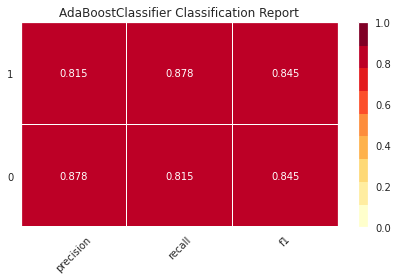

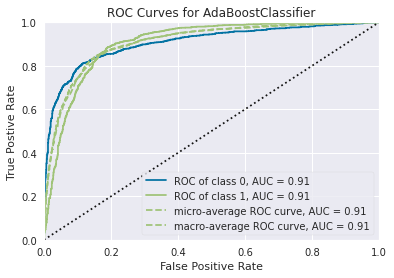

In [284]:
# Evaluate model by using confusion matix and AUC curve and F1 score
model_performance(abcl,X_train,X_test,y_train,y_test)

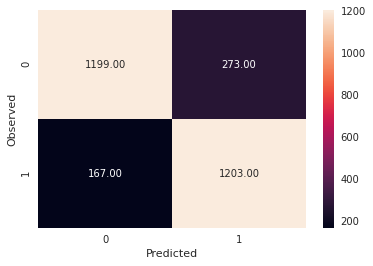

Recall: 0.878102189781022
Precision: 0.8150406504065041
F1 Score: 0.8453970484891075
Roc Auc Score: 0.8463201166296414


In [285]:
# Adaboosting performance

get_models_matrix(abcl,X_train,X_test,y_train,y_test)
# Add data to performance frame
y_predict = abcl.predict(X_test)
a = recall_score(y_test,y_predict)
b = precision_score(y_test,y_predict)
c = f1_score(y_test,y_predict)
d = roc_auc_score(y_test,y_predict)
tmpeDf = pd.DataFrame({'Method':['AdaBoosting'], 'accuracy': abcl.score(X_test,y_test),'recall':a,'precision':b,'f1_score':c,'auc':d})
performanceDf = pd.concat([performanceDf,tmpeDf])
performanceDf = performanceDf[['Method', 'accuracy','recall','precision','f1_score','auc']]


##  Gradient boosting  algorithm as ensemble model

In [286]:
dTreeGrad = DecisionTreeClassifier(criterion = "gini", max_depth=3)

gbcl = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)

# check score for adaboost model 
print("Training accuracy for gradeint boost model is :{}".format(gbcl.score(X_train,y_train)))
print("Testing accuracy for gradeint boost is :{}".format(gbcl.score(X_test,y_test)))

Training accuracy for gradeint boost model is :0.8377318654803197
Testing accuracy for gradeint boost is :0.8441238564391274


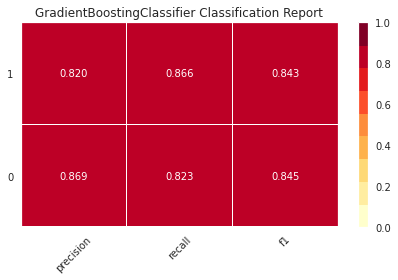

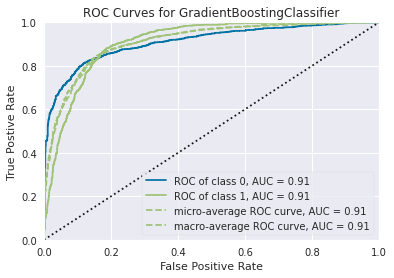

In [287]:
# Evaluate model by using confusion matix and AUC curve and F1 score
model_performance(gbcl,X_train,X_test,y_train,y_test)

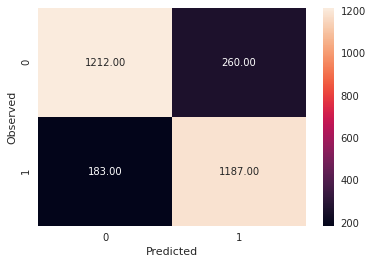

Recall: 0.8664233576642336
Precision: 0.8203178991015895
F1 Score: 0.8427405040823571
Roc Auc Score: 0.8448964614408125


In [288]:
get_models_matrix(gbcl,X_train,X_test,y_train,y_test)
# Add data to performance frame
y_predict = gbcl.predict(X_test)
a = recall_score(y_test,y_predict)
b = precision_score(y_test,y_predict)
c = f1_score(y_test,y_predict)
d = roc_auc_score(y_test,y_predict)
tmpeDf = pd.DataFrame({'Method':['GradientBoosting'], 'accuracy': gbcl.score(X_test,y_test),'recall':a,'precision':b,'f1_score':c,'auc':d})
performanceDf = pd.concat([performanceDf,tmpeDf])
performanceDf = performanceDf[['Method', 'accuracy','recall','precision','f1_score','auc']]


In [289]:
# Bonus : Use Random Forest Classifier

rfcl = RandomForestClassifier(n_estimators = 100)
rfcl = rfcl.fit(X_train, y_train)
# check score for adaboost model 
print("Training accuracy for Random forest model is :{}".format(rfcl.score(X_train,y_train)))
print("Testing accuracy for gRandom forest is :{}".format(rfcl.score(X_test,y_test)))

Training accuracy for Random forest model is :1.0
Testing accuracy for gRandom forest is :0.8272343420126671


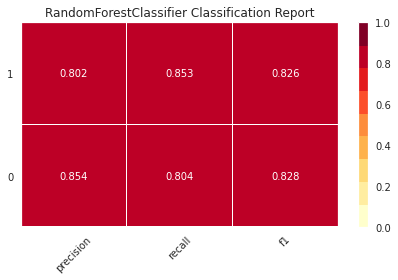

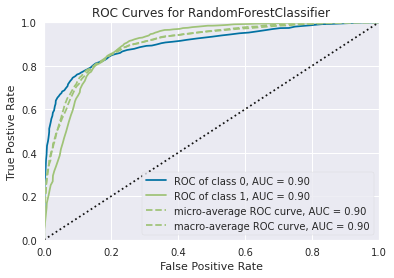

In [290]:
model_performance(rfcl,X_train,X_test,y_train,y_test)

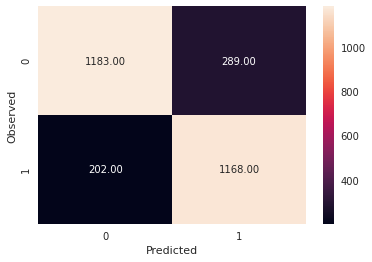

Recall: 0.8525547445255475
Precision: 0.8016472203157172
F1 Score: 0.826317651220375
Roc Auc Score: 0.8281116113932085


In [291]:
get_models_matrix(rfcl,X_train,X_test,y_train,y_test)
# Add data to performance frame
y_predict = rfcl.predict(X_test)
a = recall_score(y_test,y_predict)
b = precision_score(y_test,y_predict)
c = f1_score(y_test,y_predict)
d = roc_auc_score(y_test,y_predict)
tmpeDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': rfcl.score(X_test,y_test),'recall':a,'precision':b,'f1_score':c,'auc':d})
performanceDf = pd.concat([performanceDf,tmpeDf])
performanceDf = performanceDf[['Method', 'accuracy','recall','precision','f1_score','auc']]


In [292]:
performanceDf = performanceDf.reset_index()

# Data Frame that compare perfomance across various models

In [293]:
performanceDf

,index,Method,accuracy,recall,precision,f1_score,auc
0,0,Logistic Regression,0.806122,0.777372,0.812357,0.794480,0.805126
1,0,Decision Tree,0.795215,0.772993,0.796241,0.784444,0.794445
2,0,Bagging,0.834624,0.861314,0.808219,0.833922,0.835548
3,0,AdaBoosting,0.845179,0.878102,0.815041,0.845397,0.846320
4,0,GradientBoosting,0.844124,0.866423,0.820318,0.842741,0.844896
5,0,Random Forest,0.827234,0.852555,0.801647,0.826318,0.828112


# Final Conclustion about selecting model

### By comparing accuracy, all the models are performing decent. But in this case accuracy is not a concern. By looking at recall which is the imortant here (since bank does not want to loose their potential customers, In this way Logistic regression performs the worst. recall start to improve drametically on ensemble lerners (Adaboosting,Bagging,Gradient Boosting). also F1 score and AUC both are better in case of ensemble learning algorithm.

### Best Accurate algorithm: GradientBoosting
### Best F1 Score: Bagging
### Best AUC: Bagging

### Final Choice: In this case, Bagging is the best algorithm for select